In [61]:
import pandas as pd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, roc_curve, auc


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from numpy import mean, std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import RandomOverSampler


import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, roc_curve, auc

from sklearn.metrics import balanced_accuracy_score
from sklearn.naive_bayes import GaussianNB

In [25]:
df = pd.read_csv("final_nfl_train.csv")
df_last = df.groupby('PlayerID').agg('last')
df_mean = df.groupby('PlayerID').agg('mean')
df_train = df_mean
df_train = pd.get_dummies(df_train, drop_first=True)
df_train.drop(columns=['Year', 'DraftYear'], inplace=True)
df_train['Pick'] = df_train['Pick'].fillna(1000)
df_train['Pick'] = (df_train['Pick'] <= 32)*1
print(df_train.shape)
train_data = df_train.values
print(train_data.shape)

(8677, 59)
(8677, 59)


In [96]:
df_test = pd.read_csv("final_nfl_test.csv")
df_test_last = df_test.groupby('PlayerID').agg('last')
df_test_mean = df_test.groupby('PlayerID').agg('mean')
df_test = df_test_mean
df_test.drop(columns=['Year', 'DraftYear'], inplace=True)
df_test = df_test_mean
print(df_test.shape)
test_data = df_test.values
print(test_data.shape)

# Keep players ID in test data

my_df_test = df_test.groupby('PlayerID')
data_top = my_df_test.head()
test_ID = []
for row in data_top.index:
    test_ID.append(row)
test_ID = np.asarray((test_ID))
test_ID = test_ID.reshape((len(test_ID),1))
print(test_ID.shape)

(965, 58)
(965, 58)
(965, 1)


# Train, Test, and Validation Split

In [27]:
trainY = df_train['Pick'].values
trainX = df_train.drop('Pick', axis = 1).values
testX = test_data

# Data Augmentation

In [28]:
# to balance teh highly unbalanced dataset
ros = RandomOverSampler(random_state=0)
trainX, trainY = ros.fit_resample(trainX, trainY)

print(trainX.shape)
print(trainY.shape)

(15656, 58)
(15656,)


In [29]:
X_train, X_val, y_train, y_val = train_test_split(trainX, trainY, test_size=0.2,random_state=0)
# standirdization of teh features
sc = StandardScaler()
sc_fit = sc.fit(X_train)
X_train = sc_fit.transform(X_train)
X_val = sc_fit.transform(X_val)
testX = sc_fit.transform(testX)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((12524, 58), (12524,), (3132, 58), (3132,))

# Early Stopping

In [30]:
class MyThresholdCallback(keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["val_binary_accuracy"]
        if accuracy >= self.threshold:
            self.model.stop_training = True
            
            
early_stopping = MyThresholdCallback(threshold=1.0)

# Model1 - Deep NN

In [51]:
# define, compite, and train the model
model = Sequential([
    layers.BatchNormalization(),
    layers.Dense(1024, activation = 'relu', input_shape = [trainX.shape[1]]),
    layers.BatchNormalization(),
    layers.Dense(512, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dense(256, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 32, epochs = 150, callbacks = [early_stopping] )

Epoch 1/150
392/392 [==============================] - 2s 6ms/step - loss: 0.5222 - binary_accuracy: 0.7524 - val_loss: 0.4710 - val_binary_accuracy: 0.7778
Epoch 2/150
392/392 [==============================] - 2s 6ms/step - loss: 0.4811 - binary_accuracy: 0.7720 - val_loss: 0.4941 - val_binary_accuracy: 0.7807
Epoch 3/150
392/392 [==============================] - 2s 6ms/step - loss: 0.4660 - binary_accuracy: 0.7847 - val_loss: 0.4597 - val_binary_accuracy: 0.7963
Epoch 4/150
392/392 [==============================] - 2s 6ms/step - loss: 0.4530 - binary_accuracy: 0.7925 - val_loss: 0.4322 - val_binary_accuracy: 0.8078
Epoch 5/150
392/392 [==============================] - 2s 6ms/step - loss: 0.4439 - binary_accuracy: 0.7933 - val_loss: 0.4423 - val_binary_accuracy: 0.8033
Epoch 6/150
392/392 [==============================] - 2s 6ms/step - loss: 0.4388 - binary_accuracy: 0.7997 - val_loss: 0.4296 - val_binary_accuracy: 0.8126
Epoch 7/150
392/392 [==============================] - 2s 

Epoch 53/150
392/392 [==============================] - 2s 6ms/step - loss: 0.2238 - binary_accuracy: 0.9070 - val_loss: 0.2893 - val_binary_accuracy: 0.8959
Epoch 54/150
392/392 [==============================] - 2s 6ms/step - loss: 0.2288 - binary_accuracy: 0.9055 - val_loss: 0.2547 - val_binary_accuracy: 0.9077
Epoch 55/150
392/392 [==============================] - 3s 6ms/step - loss: 0.2216 - binary_accuracy: 0.9095 - val_loss: 0.2787 - val_binary_accuracy: 0.8911
Epoch 56/150
392/392 [==============================] - 2s 6ms/step - loss: 0.2177 - binary_accuracy: 0.9099 - val_loss: 0.2681 - val_binary_accuracy: 0.9029
Epoch 57/150
392/392 [==============================] - 3s 7ms/step - loss: 0.2174 - binary_accuracy: 0.9092 - val_loss: 0.2530 - val_binary_accuracy: 0.9058
Epoch 58/150
392/392 [==============================] - 3s 7ms/step - loss: 0.2159 - binary_accuracy: 0.9087 - val_loss: 0.2473 - val_binary_accuracy: 0.9109
Epoch 59/150
392/392 [==============================

Epoch 105/150
392/392 [==============================] - 2s 6ms/step - loss: 0.1663 - binary_accuracy: 0.9305 - val_loss: 0.2374 - val_binary_accuracy: 0.9132
Epoch 106/150
392/392 [==============================] - 2s 6ms/step - loss: 0.1605 - binary_accuracy: 0.9323 - val_loss: 0.2334 - val_binary_accuracy: 0.9234
Epoch 107/150
392/392 [==============================] - 3s 6ms/step - loss: 0.1654 - binary_accuracy: 0.9317 - val_loss: 0.2281 - val_binary_accuracy: 0.9266
Epoch 108/150
392/392 [==============================] - 2s 6ms/step - loss: 0.1678 - binary_accuracy: 0.9282 - val_loss: 0.2050 - val_binary_accuracy: 0.9304
Epoch 109/150
392/392 [==============================] - 3s 7ms/step - loss: 0.1561 - binary_accuracy: 0.9352 - val_loss: 0.2191 - val_binary_accuracy: 0.9237
Epoch 110/150
392/392 [==============================] - 3s 7ms/step - loss: 0.1623 - binary_accuracy: 0.9307 - val_loss: 0.2368 - val_binary_accuracy: 0.9272
Epoch 111/150
392/392 [=======================

# Model 2 - SVM RBF

In [41]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline

# We'll define a function to draw a nice plot of an SVM
def plot_svc(svc, X, y, h=0.02, pad=0.25):
    x_min, x_max = X[:, 0].min()-pad, X[:, 0].max()+pad
    y_min, y_max = X[:, 1].min()-pad, X[:, 1].max()+pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)

    plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=mpl.cm.Paired)
    # Support vectors indicated in plot by vertical lines
    sv = svc.support_vectors_
    plt.scatter(sv[:,0], sv[:,1], c='k', marker='x', s=100, linewidths='1')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()
    print('Number of support vectors: ', svc.support_.size)

In [56]:
from sklearn import svm
svm_svc_rbf = svm.SVC(C = 1, kernel = 'rbf', probability=True)
svm_svc_rbf_fit = svm_svc_linear.fit(X_train, y_train)

# Model 3 - Logistic Regression with L2 Reg

In [38]:
def logistic_clf(Cs=20, k_fold=3, 
                 scoring='roc_auc', 
                 penalty=True,
                 penalty_type='l1', 
                 l1_ratios=None):
    if not penalty:
        clf = LogisticRegression(penalty='none', max_iter=5000)
    else:
        if l1_ratios is None:
            clf = LogisticRegressionCV(Cs=Cs, 
                                       cv=k_fold, 
                                       scoring=scoring,
                                       penalty=penalty_type,
                                       max_iter=5000,
                                       solver='saga')
        else:
            clf = LogisticRegressionCV(Cs=Cs, 
                                       cv=k_fold, 
                                       scoring=scoring,
                                       l1_ratios=l1_ratios,
                                       penalty=penalty_type,
                                       max_iter=5000,
                                       solver='saga')
    return clf

def clf_fit_transfrom(Xtrain, ytrain, Xtest, ytest, **kwargs):
    clf = logistic_clf(**kwargs)
    best_clf = clf.fit(Xtrain, ytrain)
    train_score = best_clf.score(Xtrain, ytrain)
    test_score = best_clf.score(Xtest, ytest)
    return train_score, test_score, clf

In [57]:
train_score_0, val_score_0, clf = clf_fit_transfrom(X_train, y_train, X_val, y_val, penalty=True, Cs = 10, penalty_type='l2')
train_score_0, val_score_0 

(0.8408404989691497, 0.8340927956794066)

# Model 4: Naive Bayes

In [62]:
gnb_clf = GaussianNB().fit(X_train, y_train)

# Performance Evaluation on Validation set

In [63]:
# Since it isa binary classification, we use balanced accuracy to compare the performances on validation set
# Model 1 - NN:
pred_NN = model.predict_classes(X_val)
pred_NN = pred_NN.reshape(len(pred_NN,))
balanced_accuracy_NN = balanced_accuracy_score(pred_NN, y_val)
print('balanced_accuracy_NN: ', balanced_accuracy_NN)

# Model 2 - SVM RBF:
pred_svm = svm_svc_rbf_fit.predict(X_val)
balanced_accuracy_svm = balanced_accuracy_score(pred_svm, y_val)
print('balanced_accuracy_svm: ', balanced_accuracy_svm)


# Model 3 - Logistic Regression with L2 Reg:
pred_log = clf.predict(X_val)
balanced_accuracy_log = balanced_accuracy_score(pred_log, y_val)
print('balanced_accuracy_log: ', balanced_accuracy_log)

# Model 4 - Naive Bayes:
pred_NB = gnb_clf.predict(X_val)
balanced_accuracy_NB = balanced_accuracy_score(pred_NB, y_val)
print('balanced_accuracy_NB: ', balanced_accuracy_NB)

balanced_accuracy_NN:  0.9351182000134284
balanced_accuracy_svm:  0.783524720893142
balanced_accuracy_log:  0.766345752111867
balanced_accuracy_NB:  0.7595062834912947


# Two Ensemble Models

In [65]:
# Model 5: Ensemble - Hard Voting
pred_model5 = (pred_NN + pred_svm + pred_log + pred_NB)/4
for i in range(len(pred_model5)):
    if pred_model5[i] >= 0.5:
        pred_model5[i] = 1
    else:
        pred_model5[i] = 0
        
# Model 6: Ensemble - Weighted Voting B ased on the Performance
pred_model6 = (balanced_accuracy_NN*pred_NN + balanced_accuracy_svm*pred_svm + balanced_accuracy_log*pred_log+ balanced_accuracy_NB*pred_NB)/(balanced_accuracy_NN+balanced_accuracy_svm+balanced_accuracy_log+balanced_accuracy_NB)
for i in range(len(pred_model6)):
    if pred_model6[i] >= 0.5:
        pred_model6[i] = 1
    else:
        pred_model6[i] = 0

In [66]:
balanced_accuracy_model5 = balanced_accuracy_score(pred_model5, y_val)
print('balanced_accuracy_model5: ', balanced_accuracy_model5)

balanced_accuracy_model6 = balanced_accuracy_score(pred_model6, y_val)
print('balanced_accuracy_model6: ', balanced_accuracy_model6)

balanced_accuracy_model5:  0.8675296108291032
balanced_accuracy_model6:  0.8838737936185835


# Overall Performance on the Validation dataset

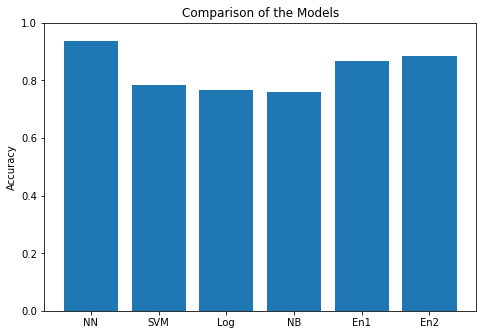

In [72]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['NN', 'SVM', 'Log', 'NB', 'En1', 'En2']
students = [0.9351182000134284, 0.783524720893142, 0.766345752111867, 0.7595062834912947, 0.8675296108291032, 0.8838737936185835]
ax.bar(langs,students)
plt.ylabel('Accuracy')
plt.title('Comparison of the Models')
plt.ylim((0,1))
plt.show()

# Prediction on the test data

# 1. NN - the best model

In [102]:
pred_NN_test = model.predict_classes(testX)
pred_NN_test = pred_NN_test.reshape(len(pred_NN_test),1)
pred_NN_test_ID = np.concatenate((test_ID,pred_NN_test), axis = 1)
np.set_printoptions(threshold=np.inf)
print('NN pred on test data: ', pred_NN_test_ID)


NN pred on test data:  [['00-0000008' '0']
 ['00-0000100' '0']
 ['00-0000129' '0']
 ['00-0000313' '0']
 ['00-0000387' '0']
 ['00-0000541' '0']
 ['00-0000627' '0']
 ['00-0000634' '0']
 ['00-0000727' '0']
 ['00-0000740' '0']
 ['00-0000781' '0']
 ['00-0000811' '0']
 ['00-0000872' '0']
 ['00-0000883' '0']
 ['00-0001058' '0']
 ['00-0001100' '0']
 ['00-0001138' '0']
 ['00-0001215' '1']
 ['00-0001478' '0']
 ['00-0001563' '0']
 ['00-0001566' '0']
 ['00-0001573' '0']
 ['00-0001611' '0']
 ['00-0001623' '0']
 ['00-0001658' '0']
 ['00-0001752' '0']
 ['00-0001759' '0']
 ['00-0001766' '0']
 ['00-0001811' '0']
 ['00-0001907' '0']
 ['00-0001922' '0']
 ['00-0001990' '0']
 ['00-0002159' '0']
 ['00-0002518' '0']
 ['00-0002604' '0']
 ['00-0002720' '0']
 ['00-0002908' '0']
 ['00-0002958' '1']
 ['00-0003239' '0']
 ['00-0003610' '0']
 ['00-0003718' '0']
 ['00-0003803' '0']
 ['00-0003825' '0']
 ['00-0003897' '0']
 ['00-0003944' '0']
 ['00-0004004' '0']
 ['00-0004073' '0']
 ['00-0004147' '0']
 ['00-0004172' '0

# 2. SVM RBF

In [ ]:


# Model 4 - Naive Bayes:
pred_NB = gnb_clf.predict(X_val)
balanced_accuracy_NB = balanced_accuracy_score(pred_NB, y_val)
print('balanced_accuracy_NB: ', balanced_accuracy_NB)

In [103]:
pred_svm_test = svm_svc_rbf_fit.predict(testX)
pred_svm_test = pred_svm_test.reshape(len(pred_svm_test),1)
pred_svm_test_ID = np.concatenate((test_ID,pred_svm_test), axis = 1)
np.set_printoptions(threshold=np.inf)
print('SVM pred on test data: ', pred_svm_test_ID)

SVM pred on test data:  [['00-0000008' '1']
 ['00-0000100' '1']
 ['00-0000129' '1']
 ['00-0000313' '0']
 ['00-0000387' '0']
 ['00-0000541' '0']
 ['00-0000627' '0']
 ['00-0000634' '0']
 ['00-0000727' '0']
 ['00-0000740' '1']
 ['00-0000781' '0']
 ['00-0000811' '0']
 ['00-0000872' '0']
 ['00-0000883' '0']
 ['00-0001058' '0']
 ['00-0001100' '1']
 ['00-0001138' '0']
 ['00-0001215' '1']
 ['00-0001478' '0']
 ['00-0001563' '1']
 ['00-0001566' '1']
 ['00-0001573' '0']
 ['00-0001611' '1']
 ['00-0001623' '1']
 ['00-0001658' '0']
 ['00-0001752' '0']
 ['00-0001759' '0']
 ['00-0001766' '0']
 ['00-0001811' '1']
 ['00-0001907' '1']
 ['00-0001922' '0']
 ['00-0001990' '1']
 ['00-0002159' '0']
 ['00-0002518' '1']
 ['00-0002604' '0']
 ['00-0002720' '0']
 ['00-0002908' '0']
 ['00-0002958' '0']
 ['00-0003239' '1']
 ['00-0003610' '1']
 ['00-0003718' '0']
 ['00-0003803' '0']
 ['00-0003825' '0']
 ['00-0003897' '0']
 ['00-0003944' '0']
 ['00-0004004' '0']
 ['00-0004073' '1']
 ['00-0004147' '0']
 ['00-0004172' '

# 3. Logistic regression

In [104]:
pred_log_test = clf.predict(testX)
pred_log_test = pred_log_test.reshape(len(pred_log_test),1)
pred_log_test_ID = np.concatenate((test_ID,pred_log_test), axis = 1)
np.set_printoptions(threshold=np.inf)
print('Logistic Regression pred on test data: ', pred_log_test_ID)

Logistic Regression pred on test data:  [['00-0000008' '1']
 ['00-0000100' '1']
 ['00-0000129' '1']
 ['00-0000313' '0']
 ['00-0000387' '0']
 ['00-0000541' '0']
 ['00-0000627' '0']
 ['00-0000634' '0']
 ['00-0000727' '0']
 ['00-0000740' '0']
 ['00-0000781' '0']
 ['00-0000811' '0']
 ['00-0000872' '0']
 ['00-0000883' '0']
 ['00-0001058' '0']
 ['00-0001100' '1']
 ['00-0001138' '0']
 ['00-0001215' '1']
 ['00-0001478' '1']
 ['00-0001563' '1']
 ['00-0001566' '1']
 ['00-0001573' '0']
 ['00-0001611' '1']
 ['00-0001623' '1']
 ['00-0001658' '0']
 ['00-0001752' '0']
 ['00-0001759' '0']
 ['00-0001766' '0']
 ['00-0001811' '1']
 ['00-0001907' '0']
 ['00-0001922' '0']
 ['00-0001990' '0']
 ['00-0002159' '0']
 ['00-0002518' '1']
 ['00-0002604' '0']
 ['00-0002720' '1']
 ['00-0002908' '0']
 ['00-0002958' '0']
 ['00-0003239' '1']
 ['00-0003610' '0']
 ['00-0003718' '0']
 ['00-0003803' '0']
 ['00-0003825' '0']
 ['00-0003897' '1']
 ['00-0003944' '0']
 ['00-0004004' '0']
 ['00-0004073' '1']
 ['00-0004147' '0']


# 4. Naive Bayes

In [106]:
pred_NB_test = gnb_clf.predict(testX)
pred_NB_test = pred_NB_test.reshape(len(pred_NB_test),1)
pred_NB_test_ID = np.concatenate((test_ID,pred_NB_test), axis = 1)
np.set_printoptions(threshold=np.inf)
print('Naive Bayes pred on test data: ', pred_NB_test_ID)

Naive Bayes pred on test data:  [['00-0000008' '1']
 ['00-0000100' '1']
 ['00-0000129' '1']
 ['00-0000313' '0']
 ['00-0000387' '1']
 ['00-0000541' '0']
 ['00-0000627' '0']
 ['00-0000634' '0']
 ['00-0000727' '1']
 ['00-0000740' '1']
 ['00-0000781' '1']
 ['00-0000811' '0']
 ['00-0000872' '0']
 ['00-0000883' '1']
 ['00-0001058' '1']
 ['00-0001100' '1']
 ['00-0001138' '0']
 ['00-0001215' '1']
 ['00-0001478' '1']
 ['00-0001563' '1']
 ['00-0001566' '1']
 ['00-0001573' '1']
 ['00-0001611' '1']
 ['00-0001623' '1']
 ['00-0001658' '1']
 ['00-0001752' '0']
 ['00-0001759' '0']
 ['00-0001766' '1']
 ['00-0001811' '1']
 ['00-0001907' '1']
 ['00-0001922' '1']
 ['00-0001990' '1']
 ['00-0002159' '1']
 ['00-0002518' '1']
 ['00-0002604' '1']
 ['00-0002720' '1']
 ['00-0002908' '1']
 ['00-0002958' '1']
 ['00-0003239' '1']
 ['00-0003610' '1']
 ['00-0003718' '0']
 ['00-0003803' '0']
 ['00-0003825' '0']
 ['00-0003897' '1']
 ['00-0003944' '1']
 ['00-0004004' '1']
 ['00-0004073' '1']
 ['00-0004147' '0']
 ['00-00

# 5. Ensemble - Hard Voting

In [107]:
# Model 5: Ensemble - Hard Voting
pred_model5_test = (pred_NN_test + pred_svm_test + pred_log_test + pred_NB_test)/4
for i in range(len(pred_model5_test)):
    if pred_model5_test[i] >= 0.5:
        pred_model5_test[i] = 1
    else:
        pred_model5_test[i] = 0
pred_model5_test = pred_model5_test.reshape(len(pred_model5_test),1)
pred_model5_test_ID = np.concatenate((test_ID,pred_model5_test), axis = 1)
np.set_printoptions(threshold=np.inf)
print('Hard Voting Ensemble pred on test data: ', pred_model5_test_ID)



Hard Voting Ensemble pred on test data:  [['00-0000008' '1.0']
 ['00-0000100' '1.0']
 ['00-0000129' '1.0']
 ['00-0000313' '0.0']
 ['00-0000387' '0.0']
 ['00-0000541' '0.0']
 ['00-0000627' '0.0']
 ['00-0000634' '0.0']
 ['00-0000727' '0.0']
 ['00-0000740' '1.0']
 ['00-0000781' '0.0']
 ['00-0000811' '0.0']
 ['00-0000872' '0.0']
 ['00-0000883' '0.0']
 ['00-0001058' '0.0']
 ['00-0001100' '1.0']
 ['00-0001138' '0.0']
 ['00-0001215' '1.0']
 ['00-0001478' '1.0']
 ['00-0001563' '1.0']
 ['00-0001566' '1.0']
 ['00-0001573' '0.0']
 ['00-0001611' '1.0']
 ['00-0001623' '1.0']
 ['00-0001658' '0.0']
 ['00-0001752' '0.0']
 ['00-0001759' '0.0']
 ['00-0001766' '0.0']
 ['00-0001811' '1.0']
 ['00-0001907' '1.0']
 ['00-0001922' '0.0']
 ['00-0001990' '1.0']
 ['00-0002159' '0.0']
 ['00-0002518' '1.0']
 ['00-0002604' '0.0']
 ['00-0002720' '1.0']
 ['00-0002908' '0.0']
 ['00-0002958' '1.0']
 ['00-0003239' '1.0']
 ['00-0003610' '1.0']
 ['00-0003718' '0.0']
 ['00-0003803' '0.0']
 ['00-0003825' '0.0']
 ['00-0003897

# 6. Ensemble - Soft Weighted Voting

In [108]:
# Model 5: Ensemble - Hard Voting
pred_model6_test = (balanced_accuracy_NN*pred_NN_test + balanced_accuracy_svm*pred_svm_test + balanced_accuracy_log*pred_log_test + balanced_accuracy_NB*pred_NB_test)/(balanced_accuracy_NN+balanced_accuracy_svm+balanced_accuracy_log+balanced_accuracy_NB)
for i in range(len(pred_model6_test)):
    if pred_model6_test[i] >= 0.5:
        pred_model6_test[i] = 1
    else:
        pred_model6_test[i] = 0
pred_model6_test = pred_model6_test.reshape(len(pred_model6_test),1)
pred_model6_test_ID = np.concatenate((test_ID,pred_model6_test), axis = 1)
np.set_printoptions(threshold=np.inf)
print('Soft Weighted Voting Ensemble pred on test data: ', pred_model6_test_ID)


Soft Weighted Voting Ensemble pred on test data:  [['00-0000008' '1.0']
 ['00-0000100' '1.0']
 ['00-0000129' '1.0']
 ['00-0000313' '0.0']
 ['00-0000387' '0.0']
 ['00-0000541' '0.0']
 ['00-0000627' '0.0']
 ['00-0000634' '0.0']
 ['00-0000727' '0.0']
 ['00-0000740' '0.0']
 ['00-0000781' '0.0']
 ['00-0000811' '0.0']
 ['00-0000872' '0.0']
 ['00-0000883' '0.0']
 ['00-0001058' '0.0']
 ['00-0001100' '1.0']
 ['00-0001138' '0.0']
 ['00-0001215' '1.0']
 ['00-0001478' '0.0']
 ['00-0001563' '1.0']
 ['00-0001566' '1.0']
 ['00-0001573' '0.0']
 ['00-0001611' '1.0']
 ['00-0001623' '1.0']
 ['00-0001658' '0.0']
 ['00-0001752' '0.0']
 ['00-0001759' '0.0']
 ['00-0001766' '0.0']
 ['00-0001811' '1.0']
 ['00-0001907' '0.0']
 ['00-0001922' '0.0']
 ['00-0001990' '0.0']
 ['00-0002159' '0.0']
 ['00-0002518' '1.0']
 ['00-0002604' '0.0']
 ['00-0002720' '0.0']
 ['00-0002908' '0.0']
 ['00-0002958' '1.0']
 ['00-0003239' '1.0']
 ['00-0003610' '0.0']
 ['00-0003718' '0.0']
 ['00-0003803' '0.0']
 ['00-0003825' '0.0']
 ['0

# Saving all the results

In [109]:
np.savez('Final_Test_Preds.npz',  NN = pred_NN_test, SVM = pred_svm_test, Log = pred_log_test, NB = pred_NB_test, En1 = pred_model5_test, En2 = pred_model6_test) 